In [1]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import pandas as pd
import numpy as np
import csv
import MeCab
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import re
import neologdn
import demoji
import emoji
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()
import japanize_matplotlib

model_dir = '/Users/iomacbookair2/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
# model_dir = '/Users/labimac/Documents/lab/DEIM2023/entity_vector/entity_vector.model.bin'
model_word2vec = KeyedVectors.load_word2vec_format(model_dir, binary=True)
mecab = MeCab.Tagger(
    '-d /opt/homebrew/lib/mecab/dic/mecab-ipadic-neologd')


In [2]:
path = "/Users/iomacbookair2/Documents/lab/DEIM2023/experiment1/thetrad/220124_thetrad.csv"
df = pd.read_csv((path))
df.sort_values(by = 'created_at', ascending = True, inplace = True)
df = df.reset_index(drop=True)
df['created_at'] = pd.to_datetime(df['created_at'])
df

,created_at,text
0,2022-01-24 15:00:00,#THETRAD
1,2022-01-24 15:00:01,#THETRAD
2,2022-01-24 15:00:01,#THETRAD
3,2022-01-24 15:00:01,１５時！#tokyofm #THETRAD
4,2022-01-24 15:00:01,#THETRAD
...,...,...
2069,2022-01-24 16:49:42,つよぽんとの様子、何となく想像がつきました😂#THETRAD #稲垣吾郎 #吉田明世
2070,2022-01-24 16:49:43,さようなら〜👋 #THETRAD
2071,2022-01-24 16:49:48,"----商品価格:1,980円----✨本日のトレンド✨壮馬くんたばこ注意諏訪部さん#THE..."
2072,2022-01-24 16:49:50,黒沢さん面白かった✨今度、森三中の3人でななにーに遊び来ないかな😊#黒沢かずこ #稲垣吾郎#...


In [3]:
def preprocess(text):
    text = emoji.replace_emoji(text, replace=' ')
    text = re.sub(r'#\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'＃\S+', '', text) # ハッシュタグを消す
    text = re.sub(r'@\S+', '', text) # @を消す
    text = re.sub(r'http?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', text) # URLをスペースに置き換え
    text = re.sub(r'https?://\S+', ' ', text) # URLをスペースに置き換え
    text = re.sub(r'!-/:-@[-`{-~]', r'', text) # 記号を消す
    text = re.sub(r'”', '', text)  # "を消す
    text = re.sub(r'"', '', text)  # "を消す
    text = re.sub(r"'", "", text) # 'を消す
    text = re.sub(r'[(`)]', '', text)
    text = re.sub(
        "[\uFF01-\uFF0F\uFF1A-\uFF20\uFF3B-\uFF40\uFF5B-\uFF65\u3000-\u303F]", '', text)  # 記号を消す
    text = re.sub(
        u'[■♯【】「」『』;・ㅂﾟˊᗜ┏━┓┗┛ヾθ、│/`:@`{-~。|∀!〇╰`′‵ˋω.*…╭∇^_￣´｀•˘д↑艸╯→°д̀ᴗ˃˂⁽⁾φ└＼※彡𖥦←ꂹ]', '', text)  # 記号を消す
    text = re.sub(r'(\d)([,.])(\d+)', r'\1\3', text) # 小数点とカンマを消す
    text = re.sub(r'\d+', '0', text) # 数字を0に置き換え
    text = text.lower() # 英字を小文字に
    text = re.sub(r"[\u3000\t\r\n]", " ", text) # 空白文字をスペースに置き換え
    text = neologdn.normalize(text)
    return text


df['text'] = df['text'].apply(preprocess)
df


,created_at,text
0,2022-01-24 15:00:00,
1,2022-01-24 15:00:01,
2,2022-01-24 15:00:01,
3,2022-01-24 15:00:01,0時
4,2022-01-24 15:00:01,
...,...,...
2069,2022-01-24 16:49:42,つよぽんとの様子何となく想像がつきました
2070,2022-01-24 16:49:43,さようなら
2071,2022-01-24 16:49:48,----商品価格0円----本日のトレンド壮馬くんたばこ注意諏訪部さん気になる評判はおすすめ...
2072,2022-01-24 16:49:50,黒沢さん面白かった今度森三中の0人でななにーに遊び来ないかな


In [4]:
# df.to_csv('preprocessed.csv', index=False)

In [5]:
import requests

url = "http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt"
r = requests.get(url)
tmp = r.text.split('\r\n')
stopwords = []
for i in range(len(tmp)):
    if len(tmp[i]) < 1:
        continue
    stopwords.append(tmp[i])

# stopwords += ["w", "ww", "www", "wwww", "wwwww", "笑",
#               "の", "し", "さ", "て", "れ", "ない", "てる",]

In [6]:
def words_list(sentence, model, mecab):
    if not sentence:
      pass
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
    #     filtered_words = [
    #         word for word in sentence_words if word not in stopwords]
    # return filtered_words
    return sentence_words


df["words"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else words_list(x, model_word2vec, mecab))
df


,created_at,text,words
0,2022-01-24 15:00:00,,0
1,2022-01-24 15:00:01,,0
2,2022-01-24 15:00:01,,0
3,2022-01-24 15:00:01,0時,[0時]
4,2022-01-24 15:00:01,,0
...,...,...,...
2069,2022-01-24 16:49:42,つよぽんとの様子何となく想像がつきました,"[つよぽん, 様子, 何となく, 想像, つき]"
2070,2022-01-24 16:49:43,さようなら,[]
2071,2022-01-24 16:49:48,----商品価格0円----本日のトレンド壮馬くんたばこ注意諏訪部さん気になる評判はおすすめ...,"[商品価格, 0円, 本日, トレンド, 壮馬, くん, たばこ, 注意, 諏訪部, さん気..."
2072,2022-01-24 16:49:50,黒沢さん面白かった今度森三中の0人でななにーに遊び来ないかな,"[黒沢, さん, 面白かっ, 今度, 森三中, 0, 人, なな, ー, 遊び, 来]"


In [7]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_words = pd.DataFrame({
    "words": groups.apply(lambda x: [word for sublist in x["words"] if type(sublist) == list for word in sublist])
})
df_words = df_words.reset_index()
df_words


,created_at,words
0,2022-01-24 15:00:00,"[0時, 吾郎ちゃん, 山崎, さん, クロストーク, お昼, ラジオ, いい, もん, 笑..."
1,2022-01-24 15:01:00,"[the, trad, tokyo, fm, trad, tokyo, fm, レコードショ..."
2,2022-01-24 15:02:00,"[臨時, 特別, 店員, れな, ちさ, やっ, ほ, ー, 吉田, くん, 山崎, さん,..."
3,2022-01-24 15:03:00,"[始まっ, ダシ, 香り, 店内, 出汁, 匂い, し, さっき, トーク, 聴か, れ, ..."
4,2022-01-24 15:04:00,"[できっこないをやらなくちゃ, ー, れな, ち, 吾郎, 店長, 吉田, 店員, 吉田, ..."
...,...,...
105,2022-01-24 16:45:00,"[黒沢, さん, 素敵, たのしかっ, ぁぁぁぁぁ, 黒沢, さん, それ, もう, 歌, ..."
106,2022-01-24 16:46:00,"[人間, 人間, なれ, www, 黒沢, さん, とても, 楽しかっ, 吾郎さん, テンシ..."
107,2022-01-24 16:47:00,"[黒沢, さん, 即興, ソング, 楽しかっ, 即興, ソング, 別れ, 黒沢, さん, 吾..."
108,2022-01-24 16:48:00,"[黒沢, さん, めちゃくちゃ, 楽しかっ, ずっと, リアルタイム, 聴け, 嬉しい, 一..."


In [8]:
df_words.to_csv('words.csv', index=False)

In [9]:
def save_wordclowd(words, index):
    if len(words) == 0:
        plt.axis("off")
    else:
        wordcloud = WordCloud(background_color="white", width=600, height=400, min_font_size=15,
                              font_path='/Users/iomacbookair2/Library/Fonts/IBMPlexSansJP-Regular.otf').generate(' '.join(words))
        plt.axis("off")
        plt.imshow(wordcloud, interpolation="bilinear")
    plt.savefig(f"{index+1}.png")
    plt.clf()


df_words.apply(lambda x: save_wordclowd(x["words"], x.name), axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
105    None
106    None
107    None
108    None
109    None
Length: 110, dtype: object

<Figure size 640x480 with 0 Axes>

In [10]:
def word_to_vec(sentence, model, mecab):
    if not sentence:
        sentence_embedding = np.zeros(200, dtype=np.float32)
    else:
        pre_sentence = sentence.split(" ")
        sentence_words = []
        for s in pre_sentence:
            tokens = mecab.parse(s).split("\n")[:-2]
            for token in tokens:
                parts = token.split("\t")
                # features = parts[1].split(",")
                if parts[1].startswith("名詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("動詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("形容詞"):
                    sentence_words.append(parts[0])
                elif parts[1].startswith("副詞"):
                    sentence_words.append(parts[0])
                # if parts[1].startswith("名詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("動詞"):
                #     sentence_words.append(features[6])
                # elif parts[1].startswith("形容詞"):
                #     sentence_words.append(features[6])
        # print(sentence_words)
        if all(re.match(r'.*[a-zA-Z].*', word) for word in sentence_words):
            sentence_embedding = np.zeros(200, dtype=np.float32)
        else:
            word_vectors = [model[word]
                            for word in sentence_words if word in model]
            if word_vectors:
                if len(word_vectors) == 0:
                    sentence_embedding = np.zeros(200, dtype=np.float32)
                else:
                    sentence_embedding = np.mean(word_vectors, axis=0)
            else:
                sentence_embedding = np.zeros(200, dtype=np.float32)
    return sentence_embedding

df["vector"] = df["text"].apply(
    lambda x: 0 if len(x) <= 1 else word_to_vec(x, model_word2vec, mecab))
df = df.drop("text", axis=1)
df = df.drop("words", axis=1)
df


,created_at,vector
0,2022-01-24 15:00:00,0
1,2022-01-24 15:00:01,0
2,2022-01-24 15:00:01,0
3,2022-01-24 15:00:01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2022-01-24 15:00:01,0
...,...,...
2069,2022-01-24 16:49:42,"[0.5319004, -0.9447762, -1.4892334, -1.223003,..."
2070,2022-01-24 16:49:43,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2071,2022-01-24 16:49:48,"[-0.13162579, 0.14014795, -0.17784132, -0.7200..."
2072,2022-01-24 16:49:50,"[-0.29918292, -0.050068337, 0.31270576, -0.030..."


In [11]:
# df.to_csv('vector.csv', index=False)

In [12]:
groups = df.groupby(pd.Grouper(key='created_at', freq='min'))
df_vectors = pd.DataFrame({
    "vectors": groups.apply(lambda x: x["vector"].tolist())
})
df_vectors = df_vectors.reset_index()
df_vectors


,created_at,vectors
0,2022-01-24 15:00:00,"[0, 0, 0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2022-01-24 15:01:00,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,2022-01-24 15:02:00,"[[-0.4857578, 0.106532805, 0.4128779, -0.93168..."
3,2022-01-24 15:03:00,"[[1.3368078, 1.051961, -1.1891502, 3.772901, 0..."
4,2022-01-24 15:04:00,"[[-0.25918388, -1.3847544, 1.2819421, -0.25139..."
...,...,...
105,2022-01-24 16:45:00,"[[-0.20916224, 0.17124565, 0.25641784, -0.1298..."
106,2022-01-24 16:46:00,"[[0.43543348, -0.23473072, -0.7048242, -0.2103..."
107,2022-01-24 16:47:00,"[[-0.50520813, 0.044300403, -0.28549796, 0.105..."
108,2022-01-24 16:48:00,"[[-0.23125729, 0.24614318, 0.21705373, -0.0281..."


In [13]:
def calc_similarity(vector1, vector2):
  similarity = cosine_similarity(vector1, vector2)[0][0]
  return similarity


def calc_average_similarity(vectors, key):
    similarities = []
    for i in range(len(vectors)):
        for j in range(i + 1, len(vectors)):
            if np.all(vectors[i] == 0) or np.all(vectors[j] == 0):
                continue
            else:
                similarity = calc_similarity(vectors[i].reshape(1, -1), vectors[j].reshape(1, -1))
            similarities.append(similarity)
    q = [0, 0.25, 0.5, 0.75, 1]
    outputs = {}
    for i in range(len(q)):
        outputs[f"q{i}"] = np.quantile(similarities, q[i])
    outputs["standard_deviation"] = np.std(similarities)
    outputs["mean"] = np.mean(similarities)
    if key == "q2":
        return outputs["q2"]
    elif key == "q1":
        return outputs["q1"]
    elif key == "q3":
        return outputs["q3"]
    elif key == "standard_deviation":
        return outputs["standard_deviation"]
    elif key == "mean":
        return outputs["mean"]


In [14]:
df_vectors["q1"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q1"))
df_vectors["q2"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q2"))
df_vectors["q3"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "q3"))
df_vectors["mean"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "mean"))
df_vectors["stdev"] = df_vectors["vectors"].apply(
    lambda x: 0 if len(x) <= 1 else calc_average_similarity(x, "standard_deviation"))
df_vectors = df_vectors.drop("vectors", axis=1)
df_vectors


,created_at,q1,q2,q3,mean,stdev
0,2022-01-24 15:00:00,0.094443,0.258790,0.392771,0.238140,0.196638
1,2022-01-24 15:01:00,-0.039430,0.123160,0.341819,0.153788,0.250989
2,2022-01-24 15:02:00,0.121782,0.239134,0.390709,0.264371,0.198926
3,2022-01-24 15:03:00,0.182142,0.310795,0.457915,0.323677,0.208730
4,2022-01-24 15:04:00,0.184223,0.324283,0.464098,0.332092,0.210471
...,...,...,...,...,...,...
105,2022-01-24 16:45:00,0.432081,0.598884,0.708530,0.568588,0.199988
106,2022-01-24 16:46:00,0.490749,0.613883,0.703436,0.589245,0.156512
107,2022-01-24 16:47:00,0.444980,0.584898,0.683469,0.562010,0.171283
108,2022-01-24 16:48:00,0.383529,0.481092,0.589152,0.467851,0.169771


In [15]:
df_vectors.to_csv('similarity_all.csv', index=False)


In [16]:
path_count = "/Users/iomacbookair2/Documents/lab/DEIM2023/experiment1/thetrad/count_all.csv"
df_count = pd.read_csv((path_count))
df_vectors["tweet"] = df_count["tweet"]
df_vectors['created_at'] = df_vectors['created_at'].astype(str)
start_time = df_vectors['created_at'].min()
start_time = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: (
    datetime.strptime(x, '%Y-%m-%d %H:%M:%S') - start_time).total_seconds() / 60+1)
df_vectors['created_at'] = df_vectors['created_at'].apply(lambda x: round(x))
df_vectors


,created_at,q1,q2,q3,mean,stdev,tweet
0,1,0.094443,0.258790,0.392771,0.238140,0.196638,31
1,2,-0.039430,0.123160,0.341819,0.153788,0.250989,17
2,3,0.121782,0.239134,0.390709,0.264371,0.198926,56
3,4,0.182142,0.310795,0.457915,0.323677,0.208730,60
4,5,0.184223,0.324283,0.464098,0.332092,0.210471,94
...,...,...,...,...,...,...,...
105,106,0.432081,0.598884,0.708530,0.568588,0.199988,42
106,107,0.490749,0.613883,0.703436,0.589245,0.156512,23
107,108,0.444980,0.584898,0.683469,0.562010,0.171283,17
108,109,0.383529,0.481092,0.589152,0.467851,0.169771,11


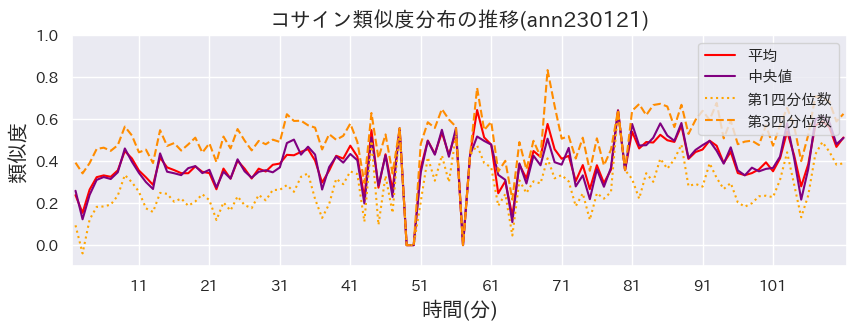

In [17]:
window_sizes = [1]
for window in window_sizes:
    df_vectors['q1'] = df_vectors['q1'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q2'] = df_vectors['q2'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['q3'] = df_vectors['q3'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.set_title(
        "コサイン類似度分布の推移(ann230121)", fontsize=15)
    indices = range(0, len(df_vectors), 10)
    plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows+0.5)
    ax.set_ylim(-0.1, 1)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("類似度", fontsize=15)
    ax.plot(df_vectors["created_at"], df_vectors["mean"], color="red",
            label="平均")
    ax.plot(df_vectors["created_at"], df_vectors["q2"], color="purple",
            label="中央値")
    ax.plot(df_vectors["created_at"], df_vectors["q1"], color="orange", linestyle="dotted",
            label="第1四分位数")
    ax.plot(df_vectors["created_at"], df_vectors["q3"], color="darkorange", linestyle="dashed",
            label="第3四分位数")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    plt.savefig('quantile_all.png')


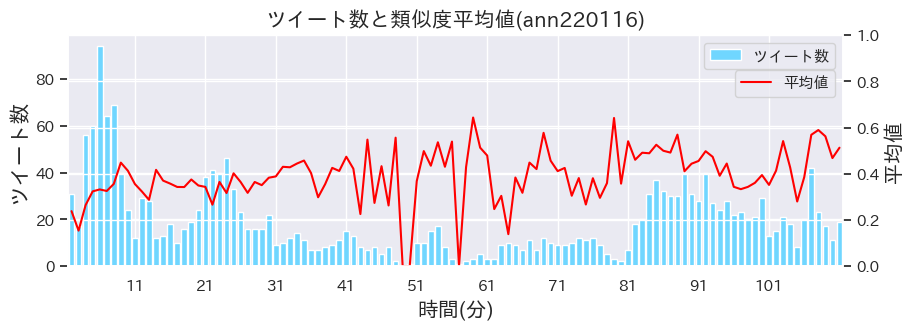

In [18]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['mean'] = df_vectors['mean'].rolling(
        window=window, min_periods=1).mean()
    # df_vectors['stdev'] = df_vectors['stdev'].rolling(
    #     window=window, min_periods=1).mean()
    # df_vectors['alpha_m'] = df_vectors['mean'] - df_vectors['stdev']
    # df_vectors['alpha_p'] = df_vectors['mean'] + df_vectors['stdev']

    fig, ax = plt.subplots(figsize=(10, 3))
    ax.set_title(
        "ツイート数と類似度平均値(ann220116)", fontsize=15)
    indices = range(0, len(df_vectors), 10)
    plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows + 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("平均値", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["mean"], color="red", label="平均値")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_m"], color="orange", linestyle="dashed")
    # ax2.plot(df_vectors["created_at"], df_vectors["alpha_p"], color="orange", linestyle="dashed",label="68%信頼区間")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.88))
    plt.savefig('mean_all.png')


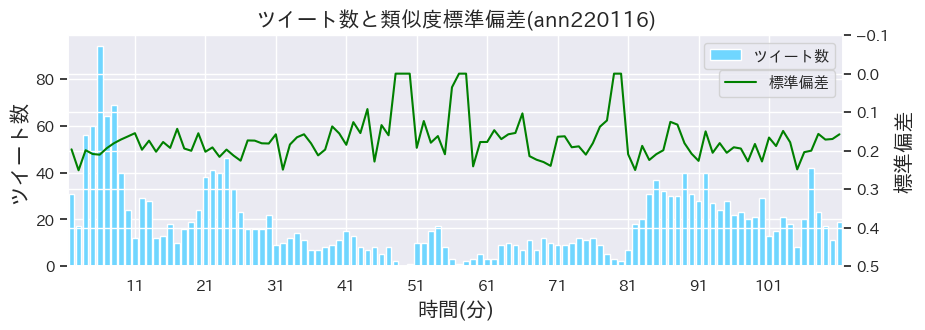

In [19]:
for window in window_sizes:
    df_vectors['tweet'] = df_vectors['tweet'].rolling(
        window=window, min_periods=1).mean()
    df_vectors['stdev'] = df_vectors['stdev'].rolling(
        window=window, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.set_title(
        "ツイート数と類似度標準偏差(ann220116)", fontsize=15)
    indices = range(0, len(df_vectors), 10)
    plt.xticks(indices, df_vectors["created_at"][indices])
    num_rows = len(df_vectors)
    ax.set_xlim(0.5, num_rows + 0.5)
    ax.set_xlabel("時間(分)", fontsize=15)
    ax.set_ylabel("ツイート数", fontsize=15)
    ax.bar(df_vectors["created_at"], df_vectors["tweet"],
           color="#70d6ff", label="ツイート数")
    ax2 = ax.twinx()
    ax2.set_ylim(0.5, -0.1)
    ax2.set_ylabel("標準偏差", fontsize=15)
    ax2.plot(df_vectors["created_at"], df_vectors["stdev"], color="green",
             label="標準偏差")
    ax.legend(loc="upper right", bbox_to_anchor=(1, 1))
    ax2.legend(loc="upper right", bbox_to_anchor=(1, 0.88))
    plt.savefig('stdev_all.png')
